# Exploration 노드 8
## 라이브러리 불러오기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. 추상적 요약
내용을 바탕으로 새로운 문장을 생성하여 본문을 요약하도록 한다. 
## 데이터 불러오기

뉴스 기사 데이터를 깃허브에서 불러온다.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
6498,"Thieves steal Pomeranian from parked car, leav...",Some unknown miscreants in Delhi stole a Pomer...
63771,Pakistan Army claims shooting down Indian dron...,The Pakistani Army on Friday claimed that it h...
60411,Get well soon: Taapsee to troll who slammed he...,"Taapsee Pannu, while responding to a troll on ..."
76371,Brother builds toilet for widowed sister on Ra...,A Ghaziabad man has started building a toilet ...
96254,"43 jawans, 20 cops injured due to stone peltin...",At least 43 CRPF jawans and 20 police personne...
21248,Harmanpreet Kaur breaks van's window with six ...,India women's T20 captain Harmanpreet Kaur bro...
77309,Govt may make Aadhaar must for real estate de...,nThe government is reportedly planning to make...
8683,I did not intend to understate my income: Niss...,Japanese carmaker Nissan's former Chairman Car...
88357,Pringles criticised for its packaging by recyc...,The Recycling Association has named Pringles i...
75279,"I-Day border meet between India, China unlikel...",The customary Border Personnel Meeting (BPM) b...


In [3]:
data=data.rename(columns={'headlines':'Summary', 'text': 'Text'})
data.head()

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


headlines와 text가 각각 요약된 데이터와 본문으로 사용할 것이기 때문에 헷갈리지 않도록 각 열의 이름을 적절하게 바꿔준다. 

## 데이터 전처리
### 중복 샘플과 결측치 제거

In [4]:
data.shape

(98401, 2)

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복 샘플은 많지 않다는 것을 알 수 있다. Summary는 간단한 요약들도 존재하기 때문에 중복이 될 수도 있다. Text는 대부분은 비교적으로 길기 때문에 중복 샘플은 정말로 중복되는 것일 확률이 높으므로 제거한다. 

In [6]:
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


결측치는 없다는 것을 알 수 있다.

### 데이터 정규화 및 불용어 제거
정규화 사전은 노드에서 제공한 내용을 그대로 불러와서 사용한다. 

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

너무 자주 등장하여 자연어 처리에서 도움이 되지 않는 불용어를 제거해야 한다. 이렇게 179개의 불용어가 있는데, 이를 모두 제거하기에 앞서 Summary의 경우 길이가 짧을 확률이 높은데 이런 요약된 데이터에서 불용어를 모두 제거하는 것이 적절한 지 확인해볼 필요가 있다. 불용어 제거만 제외한 전처리를 한 데이터를 살필 예정인데, 이 작업을 하는 함수는 다음과 같다. 

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['clean_Text'] = clean_text
data['clean_Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [14]:
data.isnull().sum()

Summary          0
Text             0
clean_Text       0
clean_Summary    0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


이후에 샘플의 최대 길이를 결정할 때 다음과 동일한 작업을 할 예정이다. 

### 샘플 최대 길이 결정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


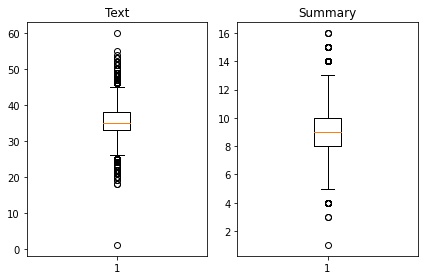

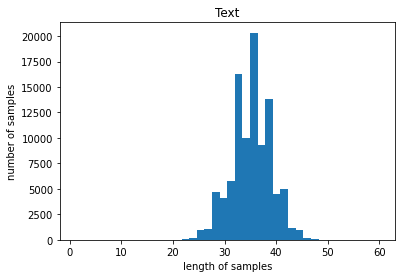

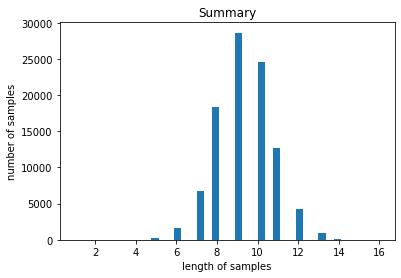

In [16]:
# Text만 불용어 제거 후 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['clean_Text']]
summary_len = [len(s.split()) for s in data['clean_Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 길이는 평균 35, 최대 60이고, Summary는 평균 9, 최대 17이다. 임의로 최대 길이를 각각 40, 11로 정하고 데이터가 어느정도 포함이 되는지를 확인하겠다. 

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
text_max_len = 40
summary_max_len = 11

below_threshold_len(text_max_len, data['clean_Text'])
below_threshold_len(summary_max_len,  data['clean_Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


데이터의 대부분이 해당 길이 내에 해당이 되기 때문에 이대로 활용해도 괜찮을 것 같다. 이 길이 보다 긴 샘플의 경우는 제외하도록 하겠다. 

In [19]:
data = data[data['clean_Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['clean_Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


### 시작 토큰과 종료 토큰 추가 + 훈련 데이터와 테스트 데이터 분리
훈련 시 사용되는 시작과 종료 토큰을 노드에서 사용한 그대로 sostoken과 eostoken으로 사용하여 문장의 시작과 끝에 추가하여 decoder_input과 decoder_target을 만든다. encoder_input은 Text를 그대로 이용한다.

In [20]:
data['decoder_input'] = data['clean_Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['clean_Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,clean_Text,clean_Summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [21]:
encoder_input = np.array(data['clean_Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

다음으로는, 직접 훈련과 테스트 데이터로 데이터를 분리한다. 순서를 무작위로 섞어서 나누는 것이 원칙이다. 

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[82373 35131 75116 ... 10999 67433 26285]


In [23]:
# 무작위 순서에 맞춰서 데이터를 동일하게 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

순서가 잘 섞인 것을 확인했으니, 이 순서대로 샘플을 8:2로 나누겠다.

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [25]:
# 훈련과 테스트 셋으로 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 정수 인코딩
#### Text 데이터
Tokenizer를 이용하여 단어 집합(vocabulary)를 만들고, 이에 맞게 훈련 데이터를 정수로 변환하는 작업을 한다. 전체 단어를 활용하지 않고 등장 빈도수가 적은 단어는 훈련에서 사용하지 않도록 한다. 특정 threshold 미만의 횟수를 등장하는 단어가 데이터에서 차지하는 비중을 확인하여 학습할 단어 집합의 크기를 결정하겠다. threshold를 10으로 해서 확인해본다. 

In [26]:
# 전체 단어 집합 생성
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [27]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64719
등장 빈도가 9번 이하인 희귀 단어의 수: 47710
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17009
단어 집합에서 희귀 단어의 비율: 73.71869157434448
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.957028269876796


9번 이하로 등장하는 단어들이 단어 집합에서 70% 이상의 큰 비중을 차지하지만, 전체 등장 빈도에서 차지하는 비중은 5.1% 정도로 매우 작은 값이기 때문에 단어 집합은 10회 이상 등장한 단어들만 포함하도록 설정하겠다. 10회 이상 등장한 단어는 167969라고 나오는데 이보다 조금 더 잘라서 16500으로 제한하겠다. 그럼 num_words를 16500으로 설정하여 Tokenizer를 다시 생성해서 단어 집합을 제한한다. 

In [28]:
src_vocab = 16500
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) 

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 확인
print(encoder_input_train[0])

[10068, 1850, 5873, 11127, 277, 317, 4295, 2115, 9840, 10069, 1, 4295, 215, 18, 10068, 139, 4295, 2115, 18, 587, 660, 13, 22, 4, 10068, 605, 4094, 502, 6369, 558, 138, 774]


#### Summary 데이터
Summary 데이터에서도 동일한 작업을 해준다.

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28438
등장 빈도가 7번 이하인 희귀 단어의 수: 20247
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8191
단어 집합에서 희귀 단어의 비율: 71.19698994303397
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.57658227666079


8회 미만으로 등장한 단어는 전체 등장 빈도의 6.8% 정도만 비중을 차지하기 때문에 모두 제거하도록 하겠다. 단어 집합의 크기를 8000 정도로 잡으면 적합하다. 

In [32]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2855, 75, 430, 122, 131, 7101, 4, 44, 193, 7101, 1517], [1, 1401, 54, 3, 1562, 424, 3417, 346, 138], [1, 96, 5417, 1608, 269, 41, 637, 1037], [1, 1901, 4097, 4, 31, 3309, 1902, 2717, 4, 1083, 344], [1, 7612, 261, 3137, 14, 28, 1097, 752, 1252, 4, 49]]
target
decoder  [[2855, 75, 430, 122, 131, 7101, 4, 44, 193, 7101, 1517, 2], [1401, 54, 3, 1562, 424, 3417, 346, 138, 2], [96, 5417, 1608, 269, 41, 637, 1037, 2], [1901, 4097, 4, 31, 3309, 1902, 2717, 4, 1083, 344, 2], [7612, 261, 3137, 14, 28, 1097, 752, 1252, 4, 49, 2]]


### 패딩 처리
데이터 전처리의 마지막으로는 샘플의 길이를 통일시키기 위해 패딩 작업을 수행한다. 이전에 결정한 최대 길이를 40과 11로 설정하고, 이보다 작은 샘플은 뒤에 숫자 0으로 채워서 길이를 맞춘다.

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계
### 인코더 설계

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

__어텐션 메커니즘__을 이용하기 위해 어텐션 층을 만들고 디코더의 출력 층에서 이용하도록 설정한다.

In [36]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2112000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 모델 훈련하기

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 154s 542ms/step - loss: 5.8453 - val_loss: 5.4395
Epoch 2/50
269/269 [==============================] - 145s 541ms/step - loss: 5.2680 - val_loss: 5.0781
Epoch 3/50
269/269 [==============================] - 146s 543ms/step - loss: 4.9327 - val_loss: 4.7882
Epoch 4/50
269/269 [==============================] - 146s 541ms/step - loss: 4.6612 - val_loss: 4.6035
Epoch 5/50
269/269 [==============================] - 145s 541ms/step - loss: 4.4441 - val_loss: 4.4322
Epoch 6/50
269/269 [==============================] - 147s 548ms/step - loss: 4.2654 - val_loss: 4.3302
Epoch 7/50
269/269 [==============================] - 146s 541ms/step - loss: 4.1149 - val_loss: 4.2243
Epoch 8/50
269/269 [==============================] - 146s 544ms/step - loss: 3.9791 - val_loss: 4.1506
Epoch 9/50
269/269 [==============================] - 145s 539ms/step - loss: 3.8588 - val_loss: 4.0740
Epoch 10/50
269/269 [==============================] - 145s 541m

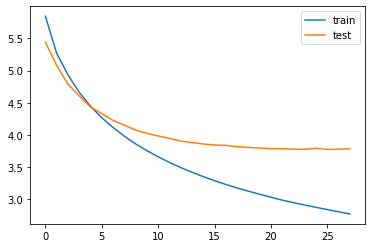

In [38]:
# loss와 val_loss 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

모델 학습은 안정적으로 수렴한 것을 확인할 수 있다. 오버피팅이 일어난 것으로 보아 성능이 떨어질 수도 있겠다는 생각이 든다. 

## 인프런스 모델 구현

In [39]:
# 사전 생성
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [41]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [42]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [43]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [44]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : amazon reportedly stop selling strategy around items cannot realise profit internally called crap items like bottled water snacks typically cost less expensive ship amazon eliminate items work manufacturers vendors certain items increase profitability 
실제 요약 : amazon may stop sale of items 
예측 요약 :  amazon to sell stake in selling clothes


원문 : per reports katrina kaif star opposite actor sidharth malhotra kargil martyr captain vikram batra biopic tentatively titled sher shah second time sidharth katrina seen together film dekho film directed vishnu produced karan johar dharma productions 
실제 요약 : katrina in sidharth starrer kargil martyr biopic report 
예측 요약 :  katrina to star opposite katrina in upcoming film report


원문 : salman khan hum saath saath hain co star filed police complaint community alleging received death threats supporting salman blackbuck poaching case instead salman made work community said even hunters said 
실제 요약 : salman co star files fir against over death 

모델은 분명 학습이 잘 된 것으로 나오지만 실제로 요약한 내용을 보면 좀 이상한 것 같다. 같은 단어들이 반복적으로 나오는 것을 확인할 수 있고, 가끔 어뚱한 내용이 나오기도 한다. 문장 길이와 단어 수를 조정해보며 실험을 해보았지만 크게 나아지지 않았는데, 결국 좋지 못한 성능의 원인은 잘 모르겠다. 

# 2. 추출적 요약
본문에서 내용을 그대로 추출하여 요약하는 방식으로 진행한다. 

In [45]:
import requests
from summa.summarizer import summarize

In [46]:
text = data['Text']
text.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
7    Weeks after ex-CBI Director Alok Verma told th...
Name: Text, dtype: object

In [47]:
example = text[0].split(".")
print("# of sentences:", len(example))
example = text[0].split(" ")
print("# of words:", len(example))

# of sentences: 4
# of words: 60


In [48]:
text[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [49]:
print('Summary:')
print(summarize(text[0], words = 20))

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [50]:
data["Extractive Summarization"] = data['Text'].apply(summarize, args=(0.1, 20))
data.head()

,Summary,Text,clean_Text,clean_Summary,decoder_input,decoder_target,Extractive Summarization
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...,The program and upGrad's 360-degree career sup...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...,"Also, customers have options to insure against..."
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...,Weeks after ex-CBI Director Alok Verma told th...


In [51]:
for i in range(50):
    print('실제 요약:', data.iloc[i]["Summary"])
    print('예측 요약:', data.iloc[i]["Extractive Summarization"])
    print()

실제 요약: upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약: The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

실제 요약: New Zealand end Rohit Sharma-led India's 12-match winning streak
예측 요약: The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

실제 요약: Aegon life iTerm insurance plan helps customers save tax
예측 요약: Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.

실제 요약: Rahat Fateh Ali Khan denies getting notice for smuggling currency
예측 요약: Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.

실제 요약: Govt directs Alok Verma to join work 1 day before his retirement
예측 요

## 추상적 요약과 추출적 요약 비교

추출적 요약에서 shuffle 이전의 본문 내용을 이용하기 위해서 data['clean_Text']에 대하여 인코딩 직전까지의 전처리 작업을 해준다. 

In [52]:
preprocessed_input=pad_sequences(src_tokenizer.texts_to_sequences(data['clean_Text']),maxlen=text_max_len, padding='post')

In [53]:
for i in range(50):
    print('실제 요약:', data.iloc[i]["Summary"])
    print("추상적 요약 예측 :", decode_sequence(preprocessed_input[i].reshape(1, text_max_len)))
    print('추출적 요약 예측:', data.iloc[i]["Extractive Summarization"])
    print()

실제 요약: upGrad learner switches to career in ML & Al with 90% salary hike
추상적 요약 예측 :  upgrad to hire upgrad data with microsoft
추출적 요약 예측: The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

실제 요약: New Zealand end Rohit Sharma-led India's 12-match winning streak
추상적 요약 예측 :  india defeat england to win their biggest runs
추출적 요약 예측: The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

실제 요약: Aegon life iTerm insurance plan helps customers save tax
추상적 요약 예측 :  insurance insurance cover insurance cover
추출적 요약 예측: Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.

실제 요약: Rahat Fateh Ali Khan denies getting notice for smuggling currency
추상적 요약 예측 :  pak denies reports of pak over casting issue
추출적

전반적으로 추출적 요약이 성능이 훨씬 좋은 걸로 나온다. 사실상 추상적 요약이 성능이 좋지 못하고 계속 엉뚱한 결과가 나오는데, 이에 비하면 추출적 요약이 훨씬 잘 요약하는 것 같다. 문법완성도 측면과 핵심단어 포함 측면에서 모두 추출적 요약이 우위에 있다. 아무래도 추출적 요약은 본문에서 문장을 그대로 가져오는 것이기 때문에 문법적으로 완성도가 높고, 핵심 단어를 포함 측면에서는 추상적 요약도 나름 잘 찾는 것 같긴 하지만, 문장으로 이해하기 힘든 형태로 포함이 되어있다. 

## 회고
이번 EX노드는 갑자기 내용이 확 어려워진 느낌이다. 특히 인코딩, 디코딩 부분과 모델의 구조에 대한 설명이 충분치 못하다는 느낌이 드는데, 이에 대한 조사는 따로 할 예정이다. 일단 노드에서 제시한 코드 바탕으로 진행을 하였다.  
  
   
__의문점:__  
* 추상적 요약의 성능이 낮은 이유를 도저히 모르겠다. 나름 노드의 코드를 그대로 따라왔고, 요약 데이터에 대해 불용어 제거도 안 했는데 실제 요약이 문법적으로 깨져서 나온다. 또한 단어도 엉뚱한 게 계속 나오는데 단어 수와 문장 길이를 바꾸어보아도 크게 바뀌지 않는다. 학습하는 데이터의 길이가 짧아서 그런 것이 아닐까 라는 생각이 들지만, 다른 파라미터와 모델 구조들을 조금 더 조정해보고 판단을 해보겠다.  
  
__어려운 점:__  
* 모델 학습이 정말 너무 오래 걸렸다. 이건 뭐 방법이 없겠지만, 이것저것 시도해봐야 되는 시점에서 한 번 모델을 학습시키는데 시간이 오래 걸리니까 너무 답답한 부분이었다. 앞으로 모델을 한 번 학습시키 전에 최대한 신중하게 준비를 해야 되겠다.  
  
__다짐:__  
* 추상적 요약에 대해 더 공부해볼 예정이다. 모델에 대한 이론적인 이해를 확실하게 다져야 앞으로 직접 이렇게 모델을 구현할 수 있을 것 같다. 
* 결국 제출기한이 다 되어서 지금 추상적 요약의 성능을 더 높이진 못 했지만, 노드에서 제시한 다양한 방법들에 대해 조사하여 이후에 이 노트북으로 돌아와서 더 시도해볼 예정이다. 